## Classification.  Handling Imbalanced Data with upsampling

## Scenario
You are working as an analyst with this internet service provider. You are provided with this historical data about your company's customers and their churn trends. Your task is to build a machine learning model that will help the company identify customers that are more likely to default/churn and thus prevent losses from such customers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_rows', 200)

In [2]:
churnData = pd.read_csv("DATA_Customer-Churn.csv")

In [3]:
churnData.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


## Check the datatypes of all the columns in the data

In [4]:
churnData.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### Converting TotalCharges column into numeric type

In [5]:
#churnData["TotalCharges"] = pd.to_numeric(churnData["TotalCharges"])
#We find some errors on that column (empty values, not NaN)

In [6]:
churnData.loc[488, 'TotalCharges']

' '

In [7]:
#If ‘coerce’, then invalid parsing will be set as NaN.
churnData["TotalCharges"] = pd.to_numeric(churnData["TotalCharges"], errors='coerce')

### Check for null values and replace them

In [8]:
churnData.isnull().values.any()

True

In [9]:
round(churnData.isna().sum()/len(churnData),4)*100

gender              0.00
SeniorCitizen       0.00
Partner             0.00
Dependents          0.00
tenure              0.00
PhoneService        0.00
OnlineSecurity      0.00
OnlineBackup        0.00
DeviceProtection    0.00
TechSupport         0.00
StreamingTV         0.00
StreamingMovies     0.00
Contract            0.00
MonthlyCharges      0.00
TotalCharges        0.16
Churn               0.00
dtype: float64

In [10]:
churnData=churnData.fillna(churnData.mean())

In [11]:
churnData["TotalCharges"].mean()

2283.3004408418697

In [12]:
churnData["TotalCharges"][churnData["TotalCharges"] > 0].mean()

2283.3004408418697

In [13]:
round(churnData.isna().sum()/len(churnData),4)*100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [14]:
churnData["Churn"] = churnData["Churn"].replace(('Yes','No'),(1,0))
churnData["Churn"]

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

## Check for imbalance data

In [15]:
churnData["Churn"].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

- Our target value is not good balanced

### Unsampling method to balance data with SMOTE

The SMOTE algorithm can be broken down into following steps:

+ Randomly pick a point from the minority class.
+ Compute the k-nearest neighbors (for some pre-specified k) for this point.
+ Add k new points somewhere between the chosen point and each of its neighbors.

In [17]:
smote = SMOTE()

In [19]:
X = churnData[['tenure', 'SeniorCitizen', 'MonthlyCharges','TotalCharges']]
y = churnData["Churn"]

In [20]:
y.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [21]:
X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

1    5174
0    5174
Name: Churn, dtype: int64

In [25]:
X_sm

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
0,1,0,29.850000,29.850000
1,34,0,56.950000,1889.500000
2,2,0,53.850000,108.150000
3,45,0,42.300000,1840.750000
4,2,0,70.700000,151.650000
...,...,...,...,...
10343,50,0,107.370010,5615.470531
10344,30,0,92.902986,2808.296125
10345,8,1,105.448002,829.442289
10346,1,0,69.593888,69.593888


### Split the data into a training set and a test set just using 4 features

- tenure: Number of months the customer has stayed with the company (Multiple different numeric values)
- SeniorCitizen: Whether the client is a senior citizen or not ( 0, 1).
- MontlyCharges: The amount charged to the customer monthly (Multiple different numeric values).
- TotalCharges: The total amount charged to the customer (Multiple different numeric values).

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.20, random_state=11)

## 01. Logistic Regression model

In [28]:
log_model = LogisticRegression() 

### Scale the features 

In [29]:
#transform data
trans = StandardScaler()
trans.fit(X_train)
X_train_mod = trans.transform(X_train)
X_test_mod  = trans.transform(X_test)

- Change again X_train_mod and X_test mod to dataframe

In [30]:
X_train_mod = pd.DataFrame(X_train_mod, columns= X.columns)
X_test_mod = pd.DataFrame(X_test_mod, columns= X.columns)

In [31]:
X_train_mod.head()

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
0,-0.985758,-0.404703,1.154082,-0.761125
1,-0.230958,-0.404703,-0.044481,-0.226463
2,-1.027691,2.470947,0.933802,-0.784289
3,-1.111558,-0.404703,-0.824401,-0.918786
4,-0.566424,2.470947,0.331542,-0.416987


In [32]:
#Fitting data
log_model.fit(X_train_mod, y_train)

LogisticRegression()

### Make Predictions

In [33]:
y_pred_train_log = log_model.predict(X_train_mod)
y_pred_test_log = log_model.predict(X_test_mod)

In [34]:
y_pred_train_log

array([1, 1, 1, ..., 0, 1, 0])

In [35]:
y_pred_test_log

array([0, 1, 1, ..., 0, 1, 1])

## Confusion Matrix

- We have to state that our positive label is Yes (and negative label is No), instead of 0, which is the default value

,Error_metric,Train,Test
0,Accuracy,0.733148,0.736232
1,Precision,0.726735,0.743714
2,Recall,0.744180,0.732381


Confusion matrix for the train set
[[3000 1154]
 [1055 3069]]


/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


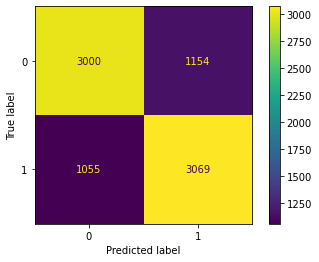



Confusion matrix for the test set
[[755 265]
 [281 769]]


/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


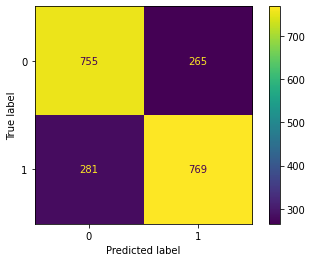

In [36]:
performance_log = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_log),
                                         precision_score(y_train, y_pred_train_log,pos_label =1),
                                         recall_score(y_train, y_pred_train_log,pos_label = 1)],
                               'Test': [accuracy_score(y_test, y_pred_test_log),
                                        precision_score(y_test, y_pred_test_log,pos_label = 1),
                                        recall_score(y_test, y_pred_test_log,pos_label = 1
                                                    )]})

display(performance_log)

print("Confusion matrix for the train set")
print(confusion_matrix(y_train,y_pred_train_log))
plot_confusion_matrix(log_model,X_train_mod,y_train, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_test, y_pred_test_log))
plot_confusion_matrix(log_model,X_test_mod,y_test, values_format = 'd')
plt.show()

## 02. KNN CLASSIFIER


In [74]:
neigh = KNeighborsClassifier(n_neighbors=27)
neigh.fit(X_train_mod, y_train)  #X_train_mod is the scaled version

KNeighborsClassifier(n_neighbors=27)

### Make Predictions on KNN

In [75]:
y_pred_train_knn = neigh.predict(X_train_mod)
y_pred_test_knn = neigh.predict(X_test_mod)

In [76]:
y_pred_train_knn

array([1, 0, 1, ..., 0, 0, 0])

In [77]:
y_pred_test_knn

array([0, 1, 1, ..., 0, 1, 1])

### Confusion matrix on KNN with k=27

,Error_metric,Train,Test
0,Accuracy,0.764677,0.757005
1,Precision,0.742101,0.745732
2,Recall,0.808681,0.790476


Confusion matrix for the train set
[[2995 1159]
 [ 789 3335]]


/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


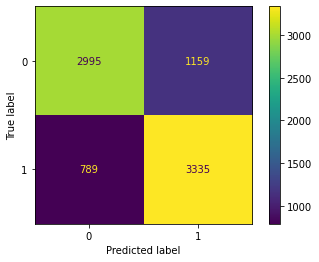



Confusion matrix for the test set
[[737 283]
 [220 830]]


/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


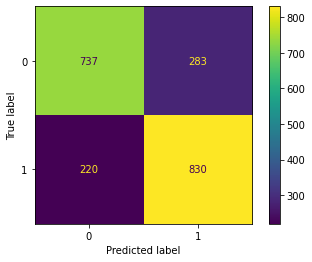

In [78]:
performance_KNN = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_knn),
                                         precision_score(y_train, y_pred_train_knn,pos_label =1),
                                         recall_score(y_train, y_pred_train_knn,pos_label = 1)],
                               'Test': [accuracy_score(y_test, y_pred_test_knn),
                                        precision_score(y_test, y_pred_test_knn,pos_label = 1),
                                        recall_score(y_test, y_pred_test_knn,pos_label = 1
                                                    )]})

display(performance_KNN)

print("Confusion matrix for the train set")
print(confusion_matrix(y_train,y_pred_train_knn))
plot_confusion_matrix(neigh,X_train_mod,y_train, values_format = 'd')
plt.show()

print()
print()

print("Confusion matrix for the test set")
print(confusion_matrix(y_test, y_pred_test_knn))
plot_confusion_matrix(neigh,X_test_mod,y_test, values_format = 'd')
plt.show()

In [79]:
# make predictions
y_pred_train_knn = neigh.predict(X_train_mod)
y_pred_test_knn  = neigh.predict(X_test_mod)

#performance_knn, _, _ = model_performance(y_train, y_pred_train_knn, y_test, y_pred_test_knn)
#performance_knn

In [80]:
y_pred_train_knn

array([1, 0, 1, ..., 0, 0, 0])

- Let's make a for loop to try others value for k neighbours

In [81]:
full_knn = pd.DataFrame()

models = {'k': [] }

for k in range(2,81):

    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train_mod, y_train)

    models['k'] = [k, neigh]

    y_pred_train_knn = neigh.predict(X_train_mod)
    y_pred_test_knn  = neigh.predict(X_test_mod)
    temp_knn = pd.DataFrame({'k': [k]*3, 'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_knn),
                                         precision_score(y_train, y_pred_train_knn,pos_label =1),
                                         recall_score(y_train, y_pred_train_knn,pos_label = 1)],
                               'Test': [accuracy_score(y_test, y_pred_test_knn),
                                        precision_score(y_test, y_pred_test_knn,pos_label = 1),
                                        recall_score(y_test, y_pred_test_knn,pos_label = 1
                                                    )]})
    full_knn = pd.concat([full_knn,temp_knn], axis=0)

full_knn

,k,Error_metric,Train,Test
0,2,Accuracy,0.874003,0.721256
1,2,Precision,0.995816,0.814913
2,2,Recall,0.750242,0.582857
0,3,Accuracy,0.868809,0.764734
1,3,Precision,0.856071,0.764319
...,...,...,...,...
1,79,Precision,0.726277,0.732797
2,79,Recall,0.803589,0.780952
0,80,Accuracy,0.751027,0.742029
1,80,Precision,0.729070,0.732432


In [82]:
### Best accuracy
full_knn[full_knn['Error_metric'] == 'Accuracy']

,k,Error_metric,Train,Test
0,2,Accuracy,0.874003,0.721256
0,3,Accuracy,0.868809,0.764734
0,4,Accuracy,0.833655,0.739614
0,5,Accuracy,0.828340,0.758454
0,6,Accuracy,0.813482,0.747343
0,7,Accuracy,0.814448,0.760870
0,8,Accuracy,0.804180,0.756522
0,9,Accuracy,0.798019,0.757488
0,10,Accuracy,0.790650,0.754106
0,11,Accuracy,0.791979,0.749758


In [83]:
full_knn_2 = full_knn.melt(id_vars=['k','Error_metric'])
full_knn_2

,k,Error_metric,variable,value
0,2,Accuracy,Train,0.874003
1,2,Precision,Train,0.995816
2,2,Recall,Train,0.750242
3,3,Accuracy,Train,0.868809
4,3,Precision,Train,0.856071
...,...,...,...,...
469,79,Precision,Test,0.732797
470,79,Recall,Test,0.780952
471,80,Accuracy,Test,0.742029
472,80,Precision,Test,0.732432


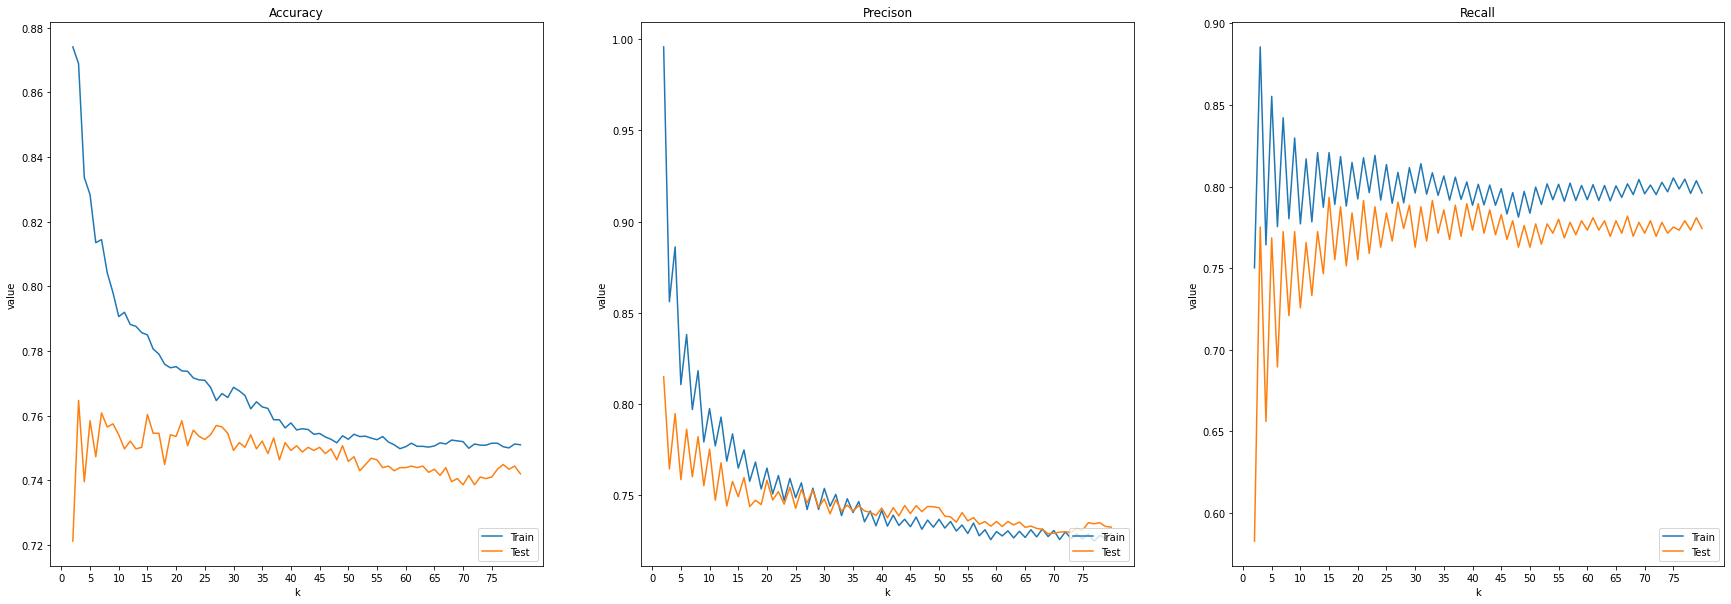

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#metrics = ['Mean error',]'Mean absolute error',...]

fig, ax = plt.subplots(1,3, figsize=(30,10))
sns.lineplot(x = 'k', y = 'value', data = full_knn_2[full_knn_2['Error_metric'] == 'Accuracy'], hue = 'variable', ax = ax[0])
ax[0].set_xticks((np.arange(0, 80, 5)))
ax[0].set_title("Accuracy")
ax[0].legend(loc='lower right')

sns.lineplot(x = 'k', y = 'value', data = full_knn_2[full_knn_2['Error_metric'] == 'Precision'], hue = 'variable', ax = ax[1])
ax[1].set_xticks((np.arange(0, 80, 5)))
ax[1].set_title("Precison")
ax[1].legend(loc='lower right')

sns.lineplot(x = 'k', y = 'value', data = full_knn_2[full_knn_2['Error_metric'] == 'Recall'], hue = 'variable', ax = ax[2])
ax[2].set_xticks((np.arange(0, 80, 5)))
ax[2].set_title("Recall")
ax[2].legend(loc='lower right')

In [85]:
full_knn_2[full_knn_2['k'] == 26]

,k,Error_metric,variable,value
72,26,Accuracy,Train,0.768785
73,26,Precision,Train,0.756738
74,26,Recall,Train,0.789767
309,26,Accuracy,Test,0.754106
310,26,Precision,Test,0.753040
311,26,Recall,Test,0.766667


In [86]:
full_knn_2[full_knn_2['k'] == 27]

,k,Error_metric,variable,value
75,27,Accuracy,Train,0.764677
76,27,Precision,Train,0.742101
77,27,Recall,Train,0.808681
312,27,Accuracy,Test,0.757005
313,27,Precision,Test,0.745732
314,27,Recall,Test,0.790476


In [87]:
full_knn_2[full_knn_2['k'] == 28]

,k,Error_metric,variable,value
78,28,Accuracy,Train,0.766852
79,28,Precision,Train,0.753818
80,28,Recall,Train,0.790010
315,28,Accuracy,Test,0.756522
316,28,Precision,Test,0.752778
317,28,Recall,Test,0.774286


For the moment I'll say 27 k

## 03. DECISION TREE

In [88]:
tree = DecisionTreeClassifier(max_depth=3)

- We don't need to use scaled data

In [89]:
tree.fit(X_train, y_train)

y_pred_train_dt = tree.predict(X_train)
y_pred_test_dt = tree.predict(X_test)


performance_dt = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train, y_pred_train_dt),
                                         precision_score(y_train, y_pred_train_dt),
                                         recall_score(y_train, y_pred_train_dt)],
                               'Test': [accuracy_score(y_test, y_pred_test_dt),
                                        precision_score(y_test, y_pred_test_dt),
                                        recall_score(y_test, y_pred_test_dt)]})

In [90]:
display(performance_dt)

,Error_metric,Train,Test
0,Accuracy,0.739792,0.748309
1,Precision,0.713851,0.735530
2,Recall,0.797284,0.786667


/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/dani/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


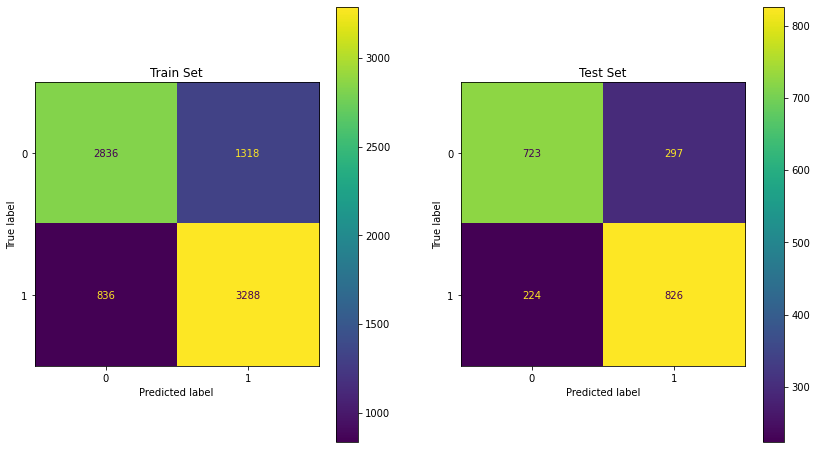

In [91]:
fig, ax = plt.subplots(1,2, figsize=(14,8))


#print("Confusion matrix for the train set")
#print(confusion_matrix(y_train,y_pred_train_dt).T)
plot_confusion_matrix(tree,X_train,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")

#print("Confusion matrix for the test set")

#print(confusion_matrix(y_test,y_pred_test_dt).T)
plot_confusion_matrix(tree,X_test,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

<BarContainer object of 4 artists>

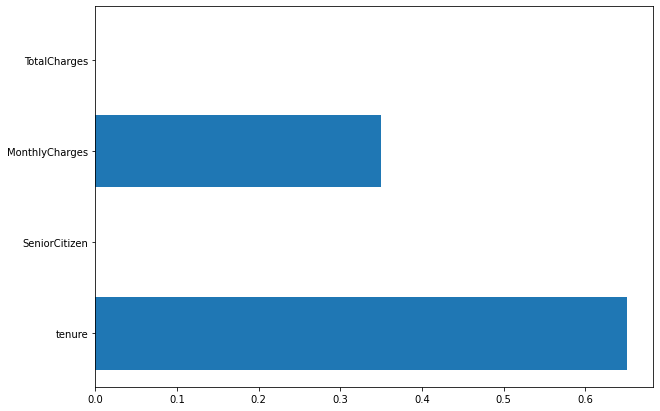

In [92]:
plt.figure(figsize=(10,7))
plt.barh(X.columns,tree.feature_importances_)

In [93]:
X["tenure"].unique()

array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39])

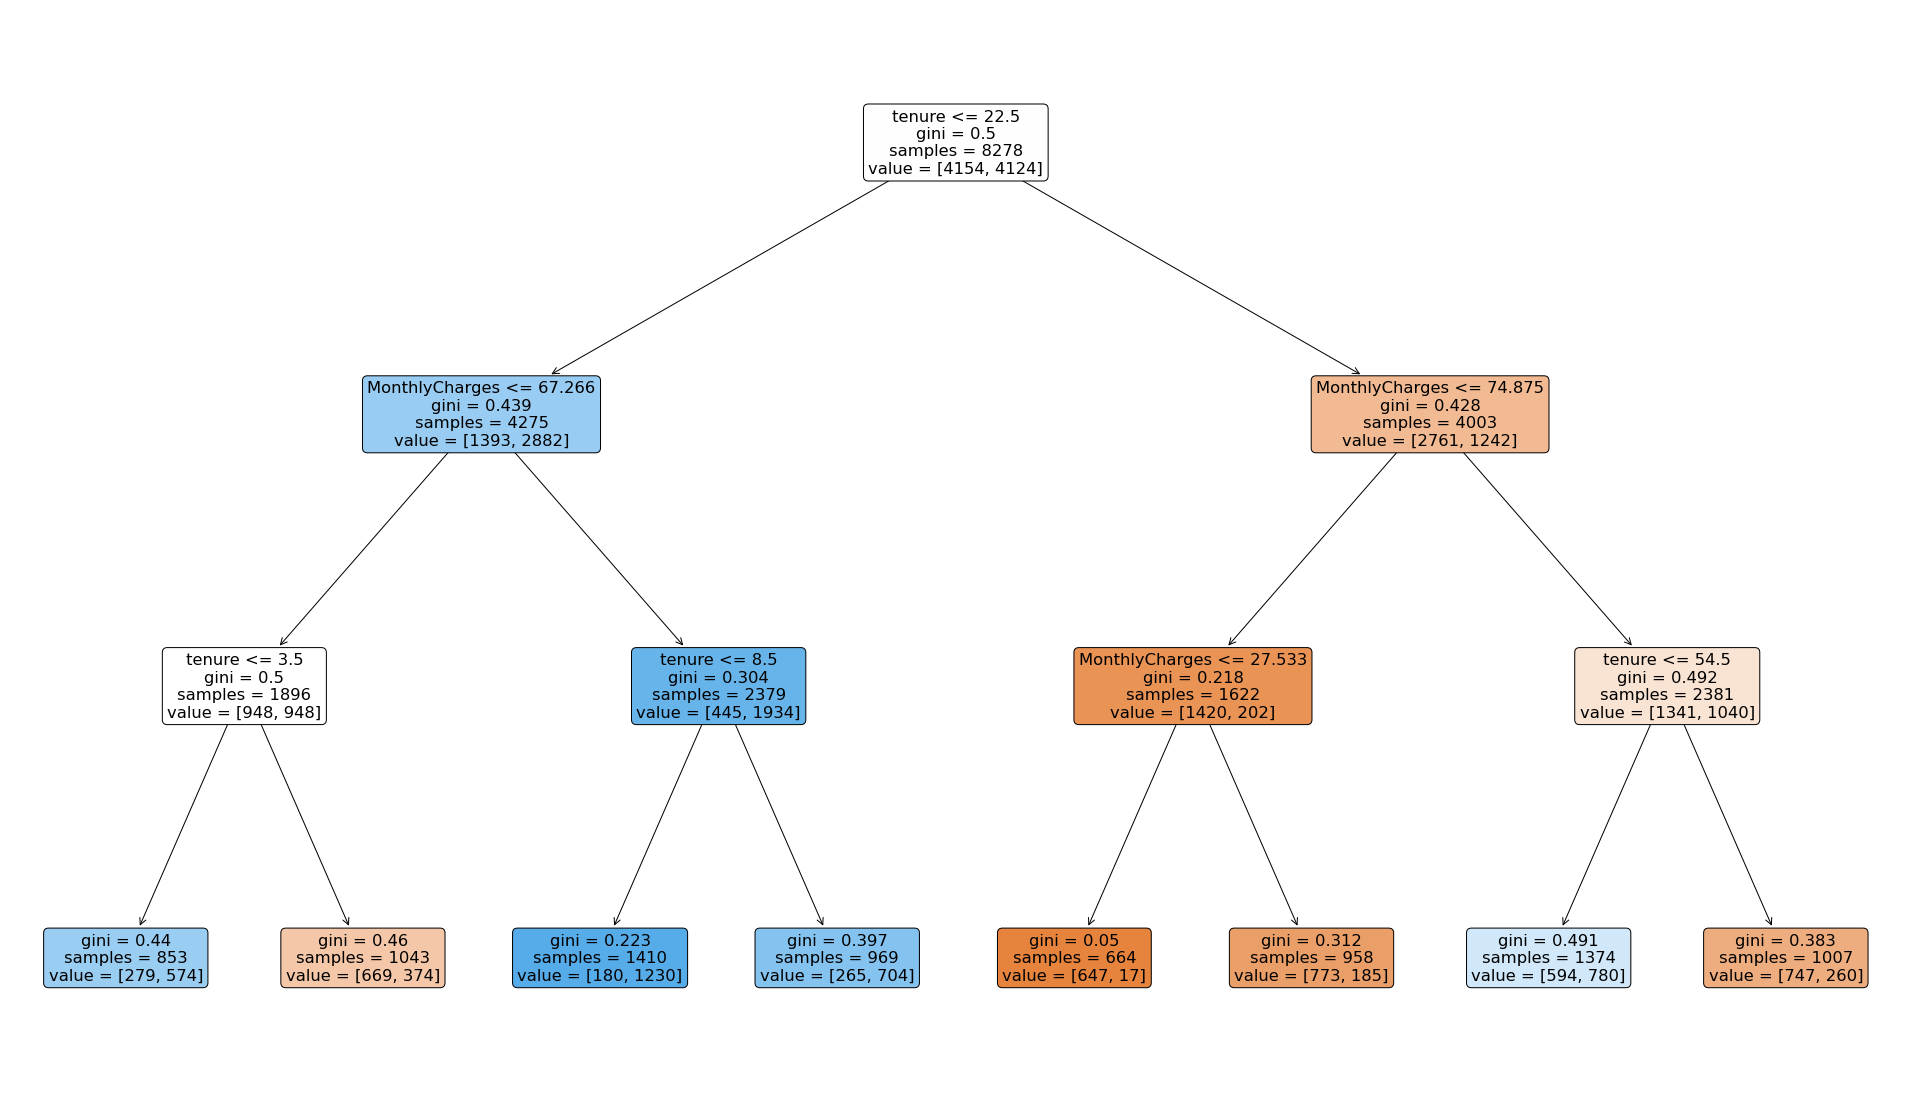

In [94]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (34,20))

plot_tree(tree,filled = True, rounded=True,feature_names=X.columns)
plt.show() 

In [95]:
len(X_train)

8278

In [96]:
X_train["tenure"].mean()

27.507731336071515

In [97]:
X_train.describe()

,tenure,SeniorCitizen,MonthlyCharges,TotalCharges
count,8278.000000,8278.000000,8278.000000,8278.000000
mean,27.507731,0.140734,68.143328,2033.731945
std,23.848807,0.347768,28.601653,2165.124921
min,0.000000,0.000000,18.250000,18.800000
25%,5.000000,0.000000,45.867650,281.687500
50%,21.000000,0.000000,74.900000,1167.836018
75%,48.000000,0.000000,90.954624,3206.697152
max,72.000000,1.000000,118.650000,8684.800000


We see that senior citizen doesn't affect (feature importance is 0), let's try not include it on the decision tree

In [98]:
performance_log

,Error_metric,Train,Test
0,Accuracy,0.733148,0.736232
1,Precision,0.726735,0.743714
2,Recall,0.744180,0.732381


In [99]:
performance_KNN

,Error_metric,Train,Test
0,Accuracy,0.764677,0.757005
1,Precision,0.742101,0.745732
2,Recall,0.808681,0.790476


In [100]:
performance_dt

,Error_metric,Train,Test
0,Accuracy,0.739792,0.748309
1,Precision,0.713851,0.735530
2,Recall,0.797284,0.786667


### K-fold cross validation on your models 

<b>Log model

In [101]:
#log_model
log_scores=cross_val_score(log_model, X_train_mod, y_train, cv=10)
log_scores

array([0.71256039, 0.73913043, 0.74758454, 0.72463768, 0.76086957,
       0.72101449, 0.72101449, 0.73671498, 0.74002418, 0.71342201])

In [102]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (log_scores.mean(), log_scores.std()))

0.73 accuracy with a standard deviation of 0.01


<b>Knn classifier

In [103]:
#neigh
neigh_scores=cross_val_score(neigh, X_train_mod, y_train, cv=10)
neigh_scores

array([0.74758454, 0.74396135, 0.75      , 0.74396135, 0.75603865,
       0.72463768, 0.74637681, 0.72101449, 0.74244256, 0.74365175])

In [104]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (neigh_scores.mean(), neigh_scores.std()))

0.74 accuracy with a standard deviation of 0.01


<b>Decision tree

In [105]:
#tree
tree_scores=cross_val_score(tree, X_train, y_train, cv=10)
tree_scores

array([0.71980676, 0.74516908, 0.74275362, 0.74275362, 0.75      ,
       0.72222222, 0.73550725, 0.73067633, 0.74848851, 0.72551391])

In [106]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (tree_scores.mean(), tree_scores.std()))

0.74 accuracy with a standard deviation of 0.01
